In [1]:
import cv2
import numpy as np
import glob

# Define the dimensions of the chessboard (rows-1, cols-1); rows, cols >= 4
CHECKERBOARD = (3, 4) 

objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

objpoints = [] 
imgpoints = [] 

images = glob.glob('chessboard/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)


cv2.destroyAllWindows()

# Perform camera calibration
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera Matrix (K):\n", K)
print("Dist:\n", dist)

Camera Matrix (K):
 [[1.59877590e+03 0.00000000e+00 5.07401915e+02]
 [0.00000000e+00 1.57986433e+03 7.23899817e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Dist:
 [[ 1.01762294e-01 -1.85222000e+00 -1.95598585e-02 -2.43105406e-03
   4.57588149e+00]]


In [2]:
from structure_from_motion_opencv import SfM as SfM_opencv

sfm1 = SfM_opencv(cv2.SIFT_create(), cv2.BFMatcher(normType=cv2.NORM_L2), K, dist)

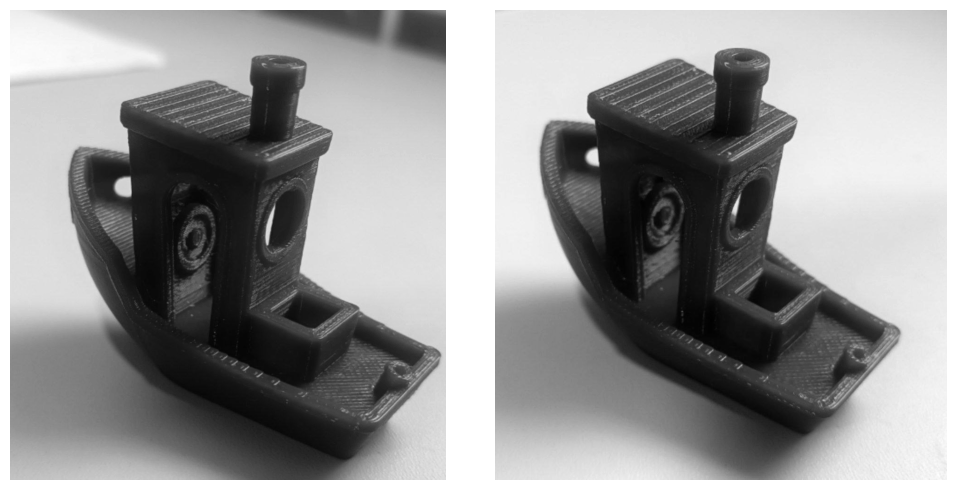

In [3]:
from utils import *
img1 = cv2.imread("benchy/1.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("benchy/2.jpg", cv2.IMREAD_GRAYSCALE)

plot_images_inline([img1, img2])

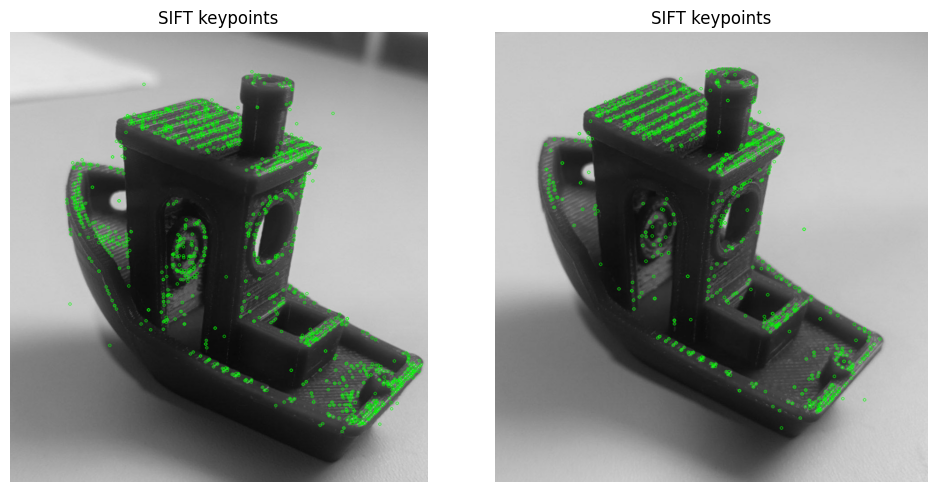

In [4]:
kp1, des1, kp2, des2 = sfm1._get_features(img1, img2)
plot_keypoints(img1, kp1, img2, kp2, titles=['SIFT keypoints', 'SIFT keypoints'])

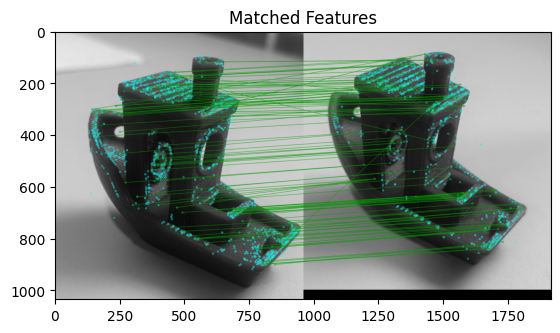

In [5]:
pts1, pts2, match, mask = sfm1._get_matched_points(kp1, kp2, des1, des2, tolerance=0.75, return_mathces=True)
plot_matches(img1, img2, kp1, kp2, match, mask)

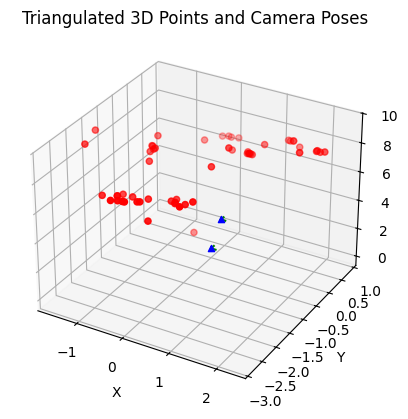

In [6]:
E, pts1, pts2 = sfm1._findEssantialMatrix(pts1, pts2)
R, t = sfm1._recoverPose(E, pts1, pts2)
points_3d = sfm1._triangulate(pts1, pts2, np.eye(3), np.zeros((3, 1)), R, t)
plot_3d_points_and_cameras(points_3d, [np.eye(3), R], [np.zeros((3, 1)), t])

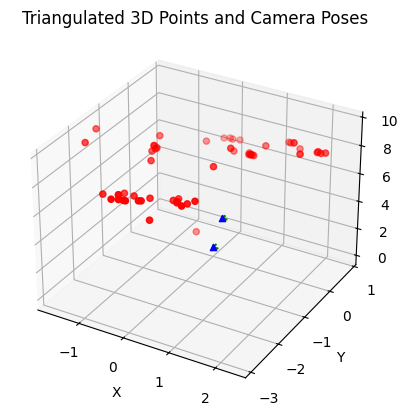

In [7]:
# Use 3d points to refine pose estimation
_, rvec, t, _ = cv2.solvePnPRansac(points_3d, pts2, sfm1.K, sfm1.dist)
rvec, t = cv2.solvePnPRefineLM(points_3d, pts2, sfm1.K, sfm1.dist, rvec, t)
R, _ = cv2.Rodrigues(rvec)

# Use initial guess for nonlinear triangulation
points_3d = sfm1.nonlinear_triangulation(points_3d, sfm1.camera_rotations[-1], sfm1.camera_translations[-1], R, t, pts1, pts2)
plot_3d_points_and_cameras(points_3d, [np.eye(3), R], [np.zeros((3, 1)), t])

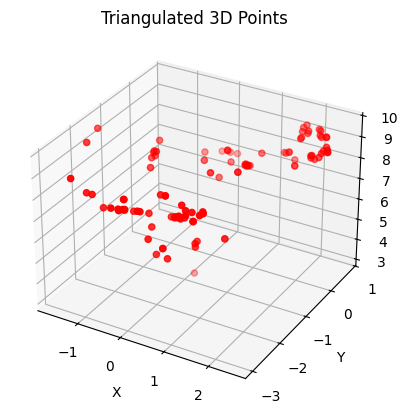

In [8]:
points_3d = sfm1.reconstruct("benchy")
plot_3d_points(points_3d)

In [9]:
from structure_from_motion_super import SfM as SfM_super
from wrappers import *

sfm2 = SfM_super(SuperPointWrapper(), SuperGlueWrapper(), K, dist)

Loaded SuperGlue model ("indoor" weights)


c:\Users\y_pod\Desktop\SfM\SuperGlue\superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path)))


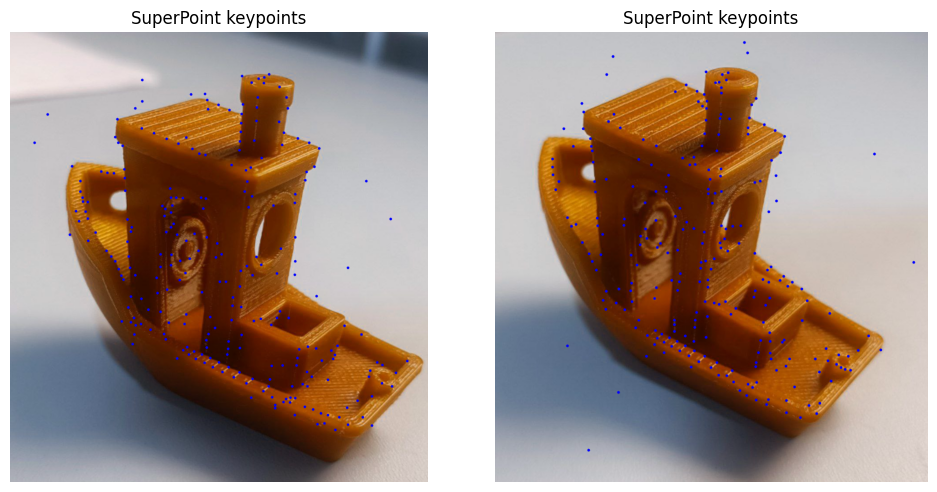

In [10]:
img1 = cv2.imread("benchy/1.jpg")
img2 = cv2.imread("benchy/2.jpg")
kp1, des1, kp2, des2, scores1, scores2 = sfm2._get_features(img1, img2)
plot_keypoints(img1, kp1, img2, kp2, is_superpoint=True, titles=['SuperPoint keypoints', 'SuperPoint keypoints'])

In [11]:
pts1, pts2 = sfm2._get_matched_points(kp1, kp2, des1, des2, scores1, scores2, img1, img2)

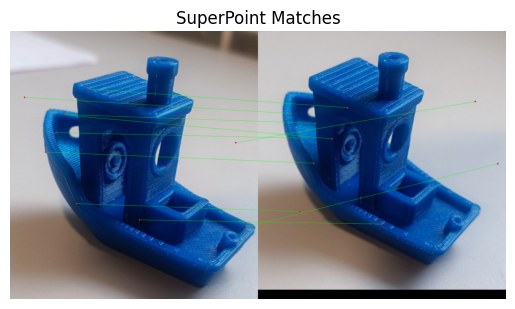

In [12]:
plot_super_matches(pts1, pts2, img1, img2)

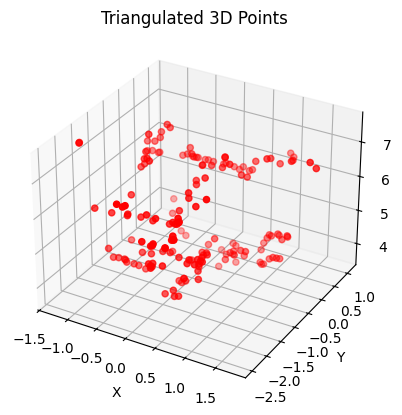

In [13]:
sfm1 = SfM_opencv(SuperPointWrapper(max_keypoints=2048), cv2.BFMatcher(normType=cv2.NORM_L2), K, dist, False)
points_3d = sfm1.reconstruct("benchy")
plot_3d_points(points_3d)